# Adevinta Fake Probability Detection

#### Check for library requirements & install if missing

In [28]:
import sys
import subprocess
import importlib

packages = ['pandas', 'numpy','pathlib','os','glob', 'textblob']
[subprocess.check_call(['pip', 'install', pkg]) 
for pkg in packages if not importlib.util.find_spec(pkg)]

[]

In [29]:
#Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt #for visualization 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import pickle

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [30]:
#Import train and test files as pandas dataframes and also drop default index column of pandas
fake_users_train = pd.read_csv("C:/Users/HP PC/Desktop/CV/Interviews/Adveinta/fake_users.csv", index_col=0)

### Analyze source data and verify if any Preprocessing/Data Cleaning is required

In [31]:
#Check Overview of the Train data
def dataoveriew(fake_users_train, message):
    print(f'{message}:\n')
    print('Number of rows: ', fake_users_train.shape[0])
    print("\nNumber of features:", fake_users_train.shape[1])
    print("\nData Features:")
    print(fake_users_train.columns.tolist())
    print("\nMissing values:", fake_users_train.isnull().sum().values.sum())
    print("\nUnique values:")
    print(fake_users_train.nunique())
    
dataoveriew(fake_users_train, 'Overview of the dataset')

Overview of the dataset:

Number of rows:  100473

Number of features: 4

Data Features:
['UserId', 'Event', 'Category', 'Fake']

Missing values: 0

Unique values:
UserId      5300
Event          5
Category       6
Fake           2
dtype: int64


In [32]:
#Check train dataframe structure details
fake_users_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100473 entries, 0 to 100472
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   UserId    100473 non-null  object
 1   Event     100473 non-null  object
 2   Category  100473 non-null  object
 3   Fake      100473 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


In [33]:
#Head and Tail on data to understand source details
fake_users_train.head()

,UserId,Event,Category,Fake
0,F7A7BF3761,click_carrousel,Phone,0
1,BA8F7A71E6,send_sms,Motor,0
2,21C64F22FC,send_email,Jobs,0
3,F9E0306603,send_sms,Jobs,0
4,1B2143BACC,click_ad,Phone,0


In [34]:
fake_users_train.tail()

,UserId,Event,Category,Fake
100468,6C3AC5DF4E,send_sms,Holidays,0
100469,22D57A742B,send_email,Leisure,0
100470,89AF1B90AD,phone_call,Real_State,0
100471,59115538F2,send_email,Jobs,0
100472,3A96C1B4ED,send_sms,Motor,0


### There are no Nulls in any of the field, and UserID is alphanumeric(Which reuires label encoding) hence we can conclude that Data is clean. No need of additional Preprocessing

In [35]:
#verify record count for Each Event
fake_users_train.groupby('Event').sum()

,Fake
Event,
click_ad,4213
click_carrousel,540
phone_call,491
send_email,4600
send_sms,515


In [36]:
#Verify record Event for Each category
fake_users_train.groupby('Category').sum()

,Fake
Category,
Holidays,1703
Jobs,1698
Leisure,1639
Motor,1718
Phone,1782
Real_State,1819


In [37]:
#Let's check Unique values
object_variables = ['UserId','Category','Event']
fake_users_train[object_variables].describe(include=['O'])

,UserId,Category,Event
count,100473,100473,100473
unique,5300,6,5
top,8DD78A5F77,Motor,send_email
freq,49,16987,22822


### Apply Label Encoding to Alphanumeric variables and one-Hot encoding to categorical variables

In [38]:
#Applying One Hot encoding for the Event Column to convert categorical feature as on-hot numeric data
train_data = pd.get_dummies(fake_users_train['Event'])
train_data.columns = ['click_ad', 'click_carrousel', 'phone_call','send_email','send_sms']
train_data = fake_users_train.join(train_data)
train_data.drop('Event', axis=1, inplace=True)
train_data.head()

,UserId,Category,Fake,click_ad,click_carrousel,phone_call,send_email,send_sms
0,F7A7BF3761,Phone,0,0,1,0,0,0
1,BA8F7A71E6,Motor,0,0,0,0,0,1
2,21C64F22FC,Jobs,0,0,0,0,1,0
3,F9E0306603,Jobs,0,0,0,0,0,1
4,1B2143BACC,Phone,0,1,0,0,0,0


In [39]:
#Applying One Hot encoding for the Category Column
train_data_cat = pd.get_dummies(fake_users_train['Category'])
train_data_cat.columns = ['Phone', 'Motor', 'Jobs','Holidays','Leisure','Real_State']
train_data = train_data.join(train_data_cat)
train_data.drop('Category', axis=1, inplace=True)
train_data.head()

,UserId,Fake,click_ad,click_carrousel,phone_call,send_email,send_sms,Phone,Motor,Jobs,Holidays,Leisure,Real_State
0,F7A7BF3761,0,0,1,0,0,0,0,0,0,0,1,0
1,BA8F7A71E6,0,0,0,0,0,1,0,0,0,1,0,0
2,21C64F22FC,0,0,0,0,1,0,0,1,0,0,0,0
3,F9E0306603,0,0,0,0,0,1,0,1,0,0,0,0
4,1B2143BACC,0,1,0,0,0,0,0,0,0,0,1,0


In [40]:
#LabelEncode the UserId column because UserId is a string whichcannot be used for model development
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
train_data["UserId_code"] = lb_make.fit_transform(train_data["UserId"])
train_data.head(5)

,UserId,Fake,click_ad,click_carrousel,phone_call,send_email,send_sms,Phone,Motor,Jobs,Holidays,Leisure,Real_State,UserId_code
0,F7A7BF3761,0,0,1,0,0,0,0,0,0,0,1,0,5110
1,BA8F7A71E6,0,0,0,0,0,1,0,0,0,1,0,0,3915
2,21C64F22FC,0,0,0,0,1,0,0,1,0,0,0,0,743
3,F9E0306603,0,0,0,0,0,1,0,1,0,0,0,0,5163
4,1B2143BACC,0,1,0,0,0,0,0,0,0,0,1,0,575


<AxesSubplot:xlabel='click_ad', ylabel='count'>

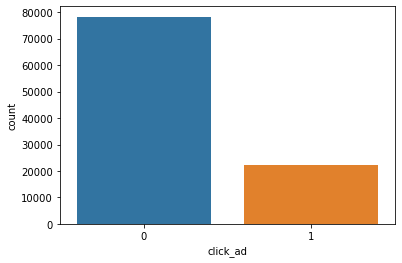

In [41]:
#Visualize target ariable click_ad
sns.countplot(x = 'click_ad', data = train_data)

<AxesSubplot:xlabel='send_email', ylabel='count'>

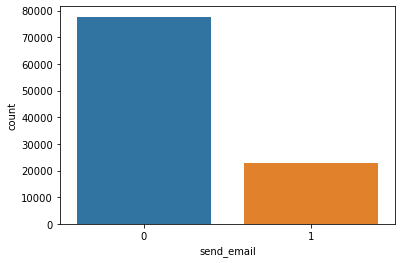

In [42]:
#Visualize target ariable send_email
sns.countplot(x = 'send_email', data = train_data)

### Read Test File And apply necessary conversions to Test file as well

In [43]:
#Read users test file
fake_users_test = pd.read_csv("C:/Users/HP PC/Desktop/CV/Interviews/Adveinta/fake_users_test.csv")
fake_users_test.head()

,UserId,Event,Category,Fake
0,03E7EE785DT,click_carrousel,Phone,0
1,F0F3098683T,click_ad,Leisure,0
2,5064A38F0DT,click_carrousel,Phone,0
3,5C8E90A354T,click_carrousel,Motor,0
4,DC1F29D286T,send_sms,Motor,0


In [44]:
#Apply Label encoding to UsersId and one hot encoding to click_ad column

#Applying One Hot encoding for the Event Column
test_data = pd.get_dummies(fake_users_test['Event'])
test_data.columns = ['click_ad', 'click_carrousel', 'phone_call','send_email','send_sms']
test_data = fake_users_test.join(test_data)
test_data.drop('Event', axis=1, inplace=True)

In [45]:
#Applying One Hot encoding for the Category Column
test_data_cat = pd.get_dummies(fake_users_test['Category'])
test_data_cat.columns = ['Phone', 'Motor', 'Jobs','Holidays','Leisure','Real_State']
test_data = test_data.join(test_data_cat)
test_data.drop('Category', axis=1, inplace=True)
test_data.head()

,UserId,Fake,click_ad,click_carrousel,phone_call,send_email,send_sms,Phone,Motor,Jobs,Holidays,Leisure,Real_State
0,03E7EE785DT,0,0,1,0,0,0,0,0,0,0,1,0
1,F0F3098683T,0,1,0,0,0,0,0,0,1,0,0,0
2,5064A38F0DT,0,0,1,0,0,0,0,0,0,0,1,0
3,5C8E90A354T,0,0,1,0,0,0,0,0,0,1,0,0
4,DC1F29D286T,0,0,0,0,0,1,0,0,0,1,0,0


In [46]:
#LabelEncode the UserId column
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
test_data["UserId_code"] = lb_make.fit_transform(test_data["UserId"])
test_data.head(5)

,UserId,Fake,click_ad,click_carrousel,phone_call,send_email,send_sms,Phone,Motor,Jobs,Holidays,Leisure,Real_State,UserId_code
0,03E7EE785DT,0,0,1,0,0,0,0,0,0,0,1,0,1
1,F0F3098683T,0,1,0,0,0,0,0,0,1,0,0,0,144
2,5064A38F0DT,0,0,1,0,0,0,0,0,0,0,1,0,49
3,5C8E90A354T,0,0,1,0,0,0,0,0,0,1,0,0,56
4,DC1F29D286T,0,0,0,0,0,1,0,0,0,1,0,0,122


# Model, predict and fetch fake Probability

### Both Send_email and click_ad are having almost same fake record count, both variables should generate similar results. First Develop model for Send_Email 

In [48]:
#Select required features for x and y. As both Send_email and click_ad are having simialr fake count lets consider Click_ad as y_value for model prediction
features = ['UserId_code', 'click_carrousel','phone_call','send_sms','Phone', 'Motor', 'Jobs','Holidays','Leisure','Real_State']
X_train = train_data[features]
Y_train = train_data["send_email"]
X_test  = test_data[features]
X_train.shape, Y_train.shape, X_test.shape

((100473, 10), (100473,), (2998, 10))

In [49]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_lg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

77.93

In [50]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.72

In [52]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_dt = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.72

### Models for click_ad

In [53]:
#Select required features for x and y. As both Send_email and click_ad are having simialr fake count lets consider Click_ad as y_value for model prediction
features = ['UserId_code', 'click_carrousel','phone_call','send_sms','Phone', 'Motor', 'Jobs','Holidays','Leisure','Real_State']
X_train = train_data[features]
Y_train = train_data["click_ad"]
X_test  = test_data[features]
X_train.shape, Y_train.shape, X_test.shape

((100473, 10), (100473,), (2998, 10))

In [54]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_lg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

77.92

In [55]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.72

In [56]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_dt = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.72

# Model Evaluation

In [15]:
#Ealuate All Models
models = pd.DataFrame({
    'Model': [ 'Logistic Regression', 
              'Random Forest','Decision Tree'],
    'Score': [acc_log, acc_random_forest, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Random Forest,85.72
2,Decision Tree,85.72
0,Logistic Regression,77.92


## While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set

In [57]:
Final_Output_File = pd.DataFrame({
        "UserId": test_data["UserId"],
        "Is_Fake_Probability": Y_pred_rf
    })

In [18]:
#Generate Output file as csv
Final_Output_File.to_csv('../output/Final_Output_File.csv', index=False)
Final_Output_File

,UserId,Is_Fake_Probability
0,03E7EE785DT,0
1,F0F3098683T,0
2,5064A38F0DT,0
3,5C8E90A354T,0
4,DC1F29D286T,0
...,...,...
2993,1B47910B14T,0
2994,35F59C96B7T,0
2995,F0F3098683T,1
2996,DF4F1E3B6ET,0
